# Simulated bifurcation example

In this script, we run through the low-level API of locaTE using the simulated bifurcating dataset from the paper, for which ground truth interactions are available.
Input data are available in the `data/` directory in `.npy` format. 
Simulations are produced using the [BoolODE](https://github.com/Murali-group/BoolODE/) package; see our [paper's reproducibility](https://github.com/zsteve/locaTE-paper/tree/main/data/simulated/Synthetic_1000/dyn-BFStrange)

## Loading required packages
We activate a local environment and then load locaTE.jl and other required packages

In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `/data/gpfs/projects/punim0638/stephenz/locaTE.jl/examples/simulated`


In [2]:
using NPZ
using NNlib
using OptimalTransport
using StatsBase
using SparseArrays
using LinearAlgebra
using Plots
using LaTeXStrings
using Graphs
using GraphSignals
using NearestNeighbors
using ProgressMeter
using Discretizers
import locaTE as lTE;
using Suppressor
pyplot()

[ Info: Precompiling locaTE [d47a2e43-82e6-47ba-a340-eddb77145d33]


Plots.PyPlotBackend()

## Load expression values from BoolODE simulation output.
We set small expression values to zero -- these are artifacts of simulation, since they are generated
using a chemical Langevin equation approximation. Alternatively, one could just use constant-width bins
for the discretizer or simulate data from a more involved Gillespie scheme.

In [3]:
DATA_DIR = "data"
# Load expression values and truncate artifactually low expression values 
X = relu.(npzread(joinpath(DATA_DIR, "X.npy")) .- 10^(-0.5));
# Load dimensionality-reduced representations 
X_pca = npzread(joinpath(DATA_DIR, "X_pca.npy"))
X_tsne = npzread(joinpath(DATA_DIR, "X_tsne2.npy"))
# Load transition matrix 
P = npzread(joinpath(DATA_DIR, "P_velo_dot.npy"))
# Load pseudotime 
dpt = npzread(joinpath(DATA_DIR, "dpt.npy"))
# Load cell-cell distance matrix 
C = npzread(joinpath(DATA_DIR, "C.npy"))
# Load ground truth cell-specific networks. 
J = permutedims(npzread(joinpath(DATA_DIR, "J.npy")), [1, 3, 2]);
# Load cluster labels
id = npzread(joinpath(DATA_DIR, "clusterid.npy"));

## Construct sparse forward and backward transition matrices for `k` steps of `P`.

In [4]:
# Construct neighbourhood kernel using QOT 
R = quadreg(ones(size(X, 1)), ones(size(X, 1)), C, 2.5 * mean(C));
# Write neighbourhood kernel to disk (for use with locaTE-cmd tool)
npzwrite(joinpath(DATA_DIR, "R.npy"), R)

In [5]:
k = 3
Q = lTE.to_backward_kernel(P)
R_sp = sparse(R)
QT_sp = sparse((Q^k)')
P_sp = sparse((P^k));

Plot forward/backward densities of the Markov chain for a selected cell

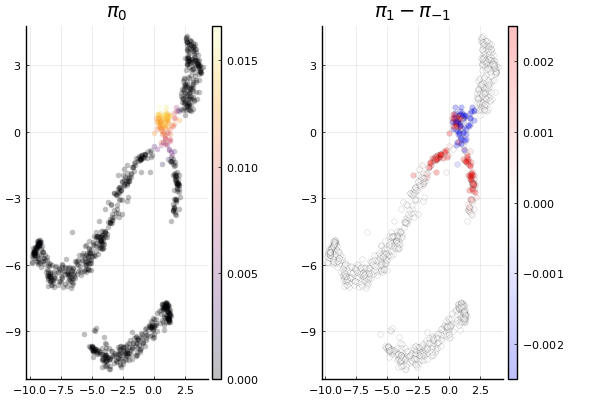

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [6]:
p0 = R[sortperm(dpt)[250], :]
plot(
    scatter(
        X_tsne[:, 1],
        X_tsne[:, 2];
        marker_z = p0,
        markerstrokewidth = 0,
        alpha = 0.25,
        title = L"π_0",
    ),
    scatter(
        X_tsne[:, 1],
        X_tsne[:, 2];
        marker_z = P_sp' * p0 - p0,
        color = :bwr,
        clim = (-0.0025, 0.0025),
        markerstrokewidth = 0.25,
        alpha = 0.25,
        title = L"π_{1} - π_{-1}",
    );
    legend = nothing,
)

Construct kNN graph and normalized Laplacian for later use

In [7]:
L = lTE.construct_normalized_laplacian(X_pca, 25);

## Estimate TE scores

In [24]:
TE = lTE.estimate_TE(X, 1:size(X, 2), 1:size(X, 2), P_sp, QT_sp, R_sp; showprogress = true);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:16


In [25]:
# using GPU
TE_gpu = lTE.estimate_TE_cu(X, 1:size(X, 2), 1:size(X, 2), P_sp, QT_sp, R_sp; showprogress = true);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


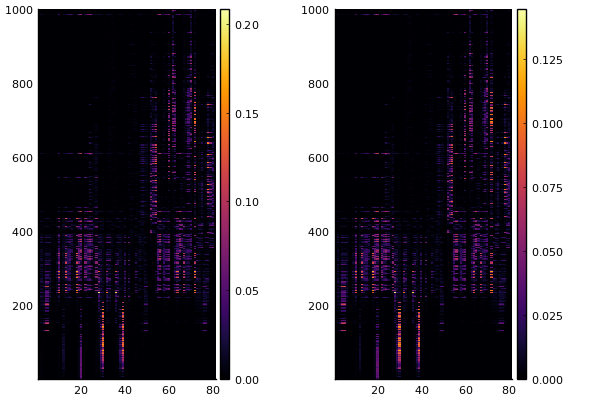

In [26]:
plot(heatmap(TE[sortperm(dpt), :]), heatmap(TE_gpu[sortperm(dpt), :]))

## Filter raw TE scores using wCLR 

In [27]:
TE_clr = lTE.apply_wclr(TE, size(X, 2))
TE_clr[isnan.(TE_clr)] .= 0;

## Denoise using graph-regularized regression

In [28]:
# weights (optional), we compute them here but do not use them in the next step
w = normalize(vec(sqrt.(sum(TE_clr .^ 2; dims = 2))), 1) 
G = lTE.fitsp(TE_clr, L; λ1 = 25.0, λ2 = 0.001, maxiter = 500);
# symmetrized version for comparison to undirected methods
G_symm = lTE.symm_row(G, size(X, 2)); 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
[ Info: ΔX = 4.194642539151613e-8, ΔZ = 9.307462834288321e-6, ΔW = 1.7731520365490278e-5
[ Info: tr(X'LX) = 0.1890747951260443, 0.5|X-G|^2 = 1.4624880389901238, |X|1 = 397.92182123611144


We can plot the TE density

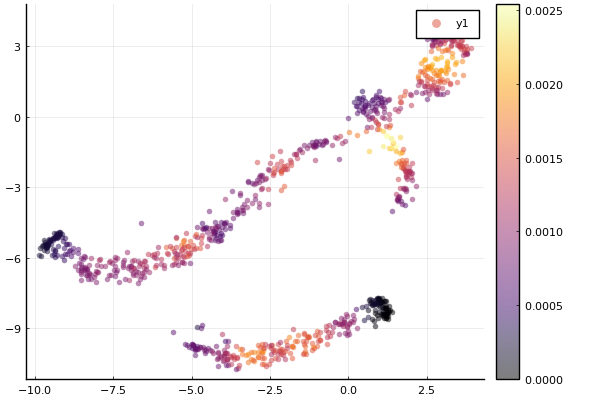

In [29]:
scatter(
    X_tsne[:, 1],
    X_tsne[:, 2];
    marker_z = w,
    markerstrokewidth = 0,
    clim = (0, quantile(w, 0.995)),
    alpha = 0.5,
)

Interaction by cell

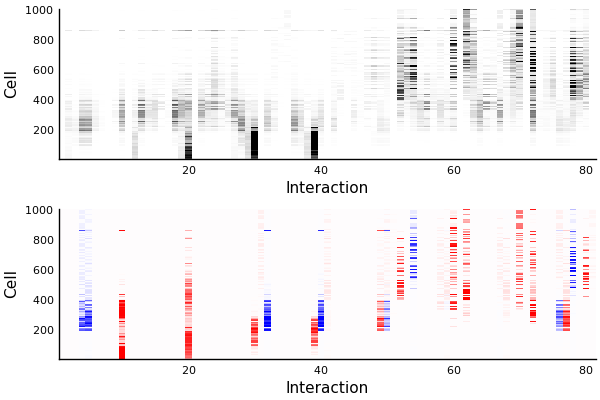

In [30]:
plot(
    heatmap(
        G[sortperm(dpt), :];
        xlabel = "Interaction",
        ylabel = "Cell",
        c = cgrad([:white, :black]),
        clim = (0, quantile(vec(G), 0.995)),
    ),
    heatmap(
        (R*reshape(J, :, size(X, 2)^2))[sortperm(dpt), :],
        c = :bwr,
        clim = (-1.5, 1.5);
        xlabel = "Interaction",
        ylabel = "Cell",
    ),
    colorbar = nothing,
    layout = (2, 1),
)

## ROC and PR curves
Since for this simulated example we have access to a ground truth, we can 
compute the receiver-operating curve and precision-recall curve to quantify the accuracy of inference. 

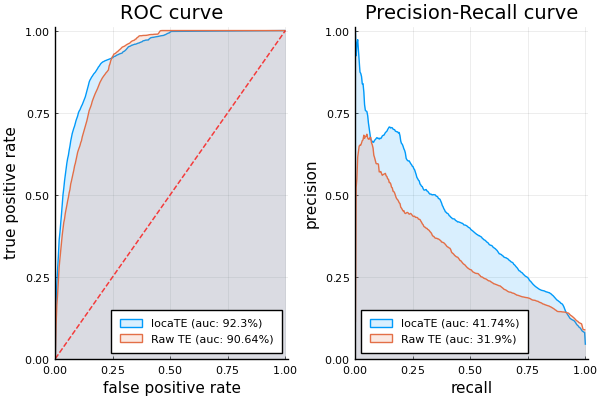

In [31]:
using EvalMetrics
plt1 = rocplot(
    vec(R * reshape(abs.(J), :, size(X, 2) * size(X, 2))) .> 0.5,
    vec(G);
    label = "locaTE",
);
rocplot!(
    vec(R * reshape(abs.(J), :, size(X, 2) * size(X, 2))) .> 0.5,
    vec(TE);
    label = "Raw TE",
);
plt2 = prplot(
    vec(R * reshape(abs.(J), :, size(X, 2) * size(X, 2))) .> 0.5,
    vec(G);
    label = "locaTE",
);
prplot!(
    vec(R * reshape(abs.(J), :, size(X, 2) * size(X, 2))) .> 0.5,
    vec(TE);
    label = "Raw TE",
);
plot(plt1, plt2)

## Plot averaged interactions by cluster
First let us plot the clusters

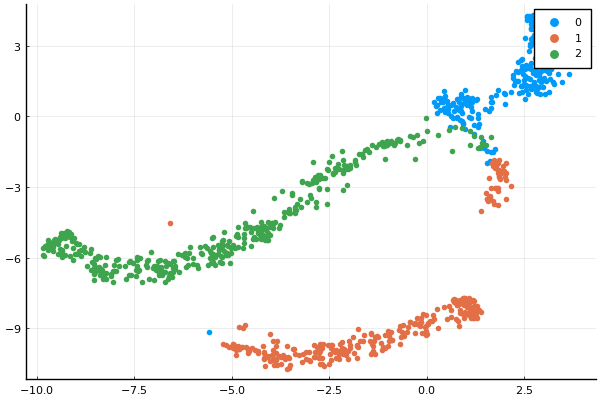

In [32]:
scatter(X_tsne[:, 1], X_tsne[:, 2]; markerstrokewidth = 0, groups = id)

Now we show the averaged interactions by cluster

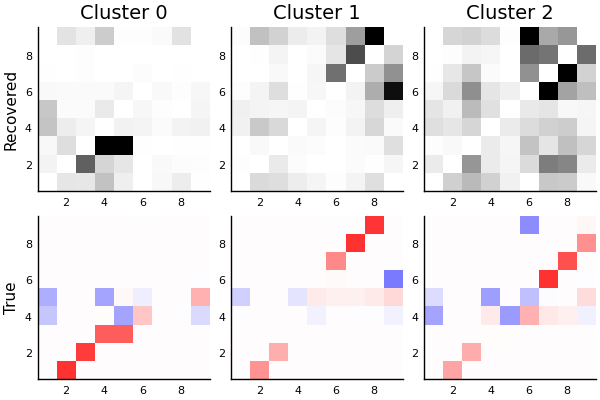

In [33]:
plt1 = plot(
    [
        heatmap(
            normalize(reshape(mean(G[id.==i, :]; dims = 1), size(X, 2), size(X, 2)), Inf),
            c = cgrad([:white, :black]),
            title = "Cluster $i",
            clim = (0, 0.75),
            ylabel = i == 0 ? "Recovered" : "",
        ) for i in sort(unique(id))
    ]...;
    layout = (1, 3),
    colorbar = nothing,
)
plt2 = plot(
    [
        heatmap(
            normalize(mean(J[id.==i, :, :]; dims = 1)[1, :, :], Inf);
            c = :bwr,
            clim = (-1.25, 1.25),
            ylabel = i == 0 ? "True" : "",
        ) for i in sort(unique(id))
    ]...;
    layout = (1, 3),
    colorbar = nothing,
)
plt = plot(plt1, plt2; layout = (2, 1))

## Factor analysis with NMF

In [34]:
qnorm(x, q) = x ./ quantile(vec(x), q)
Cg = cor(X) .^ 2;
Cg[diagind(Cg)] .= 0;
U, V, trace = lTE.fitnmf(
    relu.(qnorm(TE_clr, 0.9)),
    [I(size(G, 1)), I(size(G, 2))],
    1e-3 * I + L,
    repeat(vec(Cg), 1, size(X, 1))',
    8;
    α = 25.0,
    β = 0.0,
    λ = [10.0, 10.0],
    μ = [10.0, 10.0],
    iter = 2_500,
    initialize = :nmf,
    print_iter = 500,
    dictionary = false,
    η = 1.0,
);
G_nmf = U * V';
U .*= mean(V; dims = 1)
V ./= mean(V; dims = 1);

[ Info: Initializing NMF decomposition with nmf
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


Plot coefficients and atoms

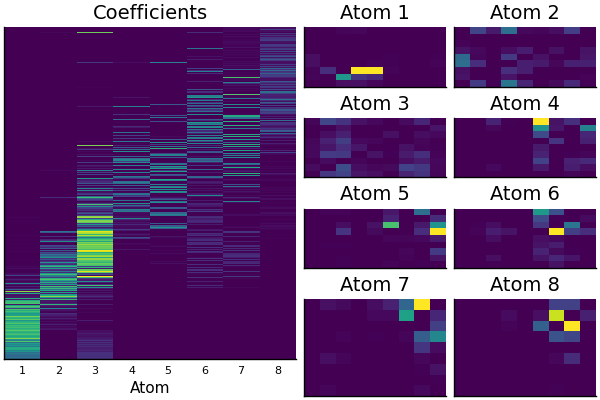

In [35]:
perm = sortperm(vec(sum((U ./ sum(U; dims = 1)) .* dpt; dims = 1))) # sort atoms by order of activation
plt1 = heatmap(
    U[sortperm(dpt), perm],
    colorbar = nothing,
    yaxis = nothing,
    title = "Coefficients",
    xticks = (1:size(U, 2)),
    xlabel = "Atom",
    c = :viridis,
);
plt2 = plot(
    [
        heatmap(
            reshape(v, size(X, 2), size(X, 2));
            title = "Atom $i",
            axis = nothing,
            clim = (0, quantile(vec(V), 0.99)),
            c = :viridis,
        ) for (i, v) in enumerate(eachcol(V[:, perm]))
    ]...;
    colorbar = nothing,
    layout = (4, 2),
);
plot(plt1, plt2)

## Factor analysis with NTF

In [36]:
using TensorToolbox
Cg = cor(X) .^ 2;
Cg[diagind(Cg)] .= 0;
S, A, trace = lTE.fitntf(
    Array(reshape(qnorm(TE_clr, 0.9), :, size(X, 2), size(X, 2))),
    [I(size(X, 1)), I(size(X, 2)), I(size(X, 2))],
    1e-3 * I + L,
    repeat(reshape(Cg, 1, size(X, 2), size(X, 2)), size(X, 1)),
    [1, 1, 1],
    [1, 1, 1],
    25.0,
    0.0,
    16;
    iter = 500,
    dictionary = false,
    η = 1.0,
);
G_ntf = reshape(ttm(S, A, 1:length(A)), :, size(X, 2)^2);
ntf_atoms = [x * y' for (x, y) in zip(eachcol(A[2]), eachcol(A[3]))];
A[1] .*= mean.(ntf_atoms)'
A[2] ./= sqrt.(mean.(ntf_atoms))'
A[3] ./= sqrt.(mean.(ntf_atoms))'
ntf_atoms ./= mean.(ntf_atoms);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


Cluster atoms and then plot

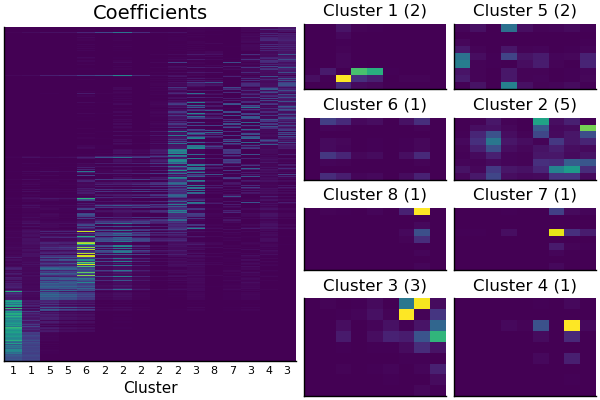

In [37]:
using Clustering
hc = hclust(1 .- cor(A[1]))
clusts = cutree(hc; k = 8)
ntf_atoms_clust_activity =
    hcat([sum(A[1][:, clusts.==i]; dims = 2) for i = 1:length(unique(clusts))]...)
ntf_atoms_clust = [sum(ntf_atoms[clusts.==i]) for i = 1:length(unique(clusts))];
ntf_atoms_clust_nums = [sum(clusts .== i) for i = 1:length(unique(clusts))];
perm_clust = sortperm(
    vec(
        sum(
            (ntf_atoms_clust_activity ./ sum(ntf_atoms_clust_activity; dims = 1)) .* dpt;
            dims = 1,
        ),
    ),
)
perm = sortperm(vec(sum((A[1] ./ sum(A[1]; dims = 1)) .* dpt; dims = 1)));
# Plot coefficients and atoms
plt2 = plot(
    [
        heatmap(
            x;
            title = "Cluster $(perm_clust[i]) ($(ntf_atoms_clust_nums[perm_clust[i]]))",
            axis = nothing,
            titlefontsize = 12,
            clim = (0, quantile(vec(hcat(ntf_atoms...)), 0.999)),
            c = :viridis,
        ) for (i, x) in enumerate(ntf_atoms_clust[perm_clust])
    ]...;
    colorbar = nothing,
    layout = (4, 2),
);
plt1 = heatmap(
    A[1][sortperm(dpt), perm],
    colorbar = nothing,
    yaxis = nothing,
    title = "Coefficients",
    xticks = (1:size(A[1], 2), clusts[perm]),
    xlabel = "Cluster",
    c = :viridis,
);
plot(plt1, plt2)

In [38]:
macro bash_str(s) open(`bash`,"w",stdout) do io; print(io, s); end; end
bash"""
JULIA_NUM_THREADS=8 julia --project=. ../../src/locaTE_cmd.jl --tau 3 --lambda1 25 --lambda2 0.001 --outdir locaTE_output/ --cutoff 0.3 data/X.npy data/X_pca.npy data/P_velo_dot.npy data/R.npy 
"""

[ Info: Reading input...
[ Info: Estimating TE scores...
Progress: 100%|█████████████████████████████████████████| Time: 0:02:19
[ Info: Denoising...
Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
[ Info: ΔX = 1.061549869528493e-8, ΔZ = 4.270469710493385e-9, ΔW = 5.6581991675561105e-6
[ Info: tr(X'LX) = 0.18290084236710943, 0.5|X-G|^2 = 1.3046475777520536, |X|1 = 404.13889079276174
